In [1]:
# from google.colab import drive

# drive.mount('/content/drive', force_remount=True)

# # 输入daseCV所在的路径
# # 'daseCV' 文件夹包括 '.py', 'classifiers' 和'datasets'文件夹
# # 例如 'CV/assignments/assignment1/daseCV/'
# FOLDERNAME = None

# assert FOLDERNAME is not None, "[!] Enter the foldername."

# %cd drive/My\ Drive
# %cp -r $FOLDERNAME ../../
# %cd ../../
# %cd daseCV/datasets/
# !bash get_datasets.sh
# %cd ../../

# 实现一个神经网络

在这个练习中，我们将开发一个具有全连接层的神经网络来进行分类任务，并在CIFAR-10数据集上进行测试。

In [2]:
# 一些初始化设置

import numpy as np
import matplotlib.pyplot as plt

from daseCV.classifiers.neural_net import TwoLayerNet

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # 设置默认绘图大小
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 自动重载外部模块的详细资料可以查看下面链接
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

在文件`daseCV/classifiers/neural_net`中使用一个类`TwoLayerNet`表示我们的网络实例。网络参数存储在实例变量`self.params`中, 其中键是参数名，值是numpy数组。
下面，我们初始化玩具数据和一个玩具模型，我们将使用它来开发具体代码。

In [3]:
# 创建一个小网络和一些玩具数据
# 注意，我们设置了可重复实验的随机种子。

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# 前向传播：计算scores

打开文件`daseCV/classifiers/neural_net`，查看`TwoLayerNet.loss`函数。这个函数与你之前在SVM和Softmax写的损失函数非常相似：输入数据和权重，计算类别的scores、loss和参数上的梯度。

实现前向传播的第一部分：使用权重和偏差来计算所有输入的scores。

In [4]:
scores = net.loss(X)
print('Your scores:')
print(scores)
print()
print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print()

# The difference should be very small. We get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.6802720745909845e-08


# 反向传播: 计算损失

在同一个函数中，编码实现第二个部分，计算损失值。

In [5]:
loss, _ = net.loss(X, y, reg=0.05) #reg为0.1
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
0.018965419606063127


# 反向传播

实现函数的其余部分。计算关于变量`W1`, `b1`, `W2`, `b2`的梯度。当你正确实现了前向传播的代码后(hopefully!)，你可以用数值梯度检查debug你的反向传播:

In [6]:
from daseCV.gradient_check import eval_numerical_gradient

# 使用数值梯度检查反向传播的代码。
# 如果你的代码是正确的，那么对于W1、W2、b1和b2，
# 数值梯度和解析梯度之间的差异应该小于1e-8。

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.440708e-09
b2 max relative error: 1.276034e-10
W1 max relative error: 4.090896e-09
b1 max relative error: 1.555470e-09


# 训练网络

我们使用随机梯度下降(SGD)训练网络，类似于SVM和Softmax。查看`TwoLayerNet.train`函数并填写训练代码中缺失的部分。这与SVM和Softmax分类器的训练过程非常相似。您还必须实现`TwoLayerNet.predict`，即在网络训练过程中周期性地进行预测，以持续追踪网络的准确率

当你完成了这个函数吼，运行下面的代码，在玩具数据上训练一个两层网络。你的训练损失应该少于0.02。

Final training loss:  0.017143645815455258


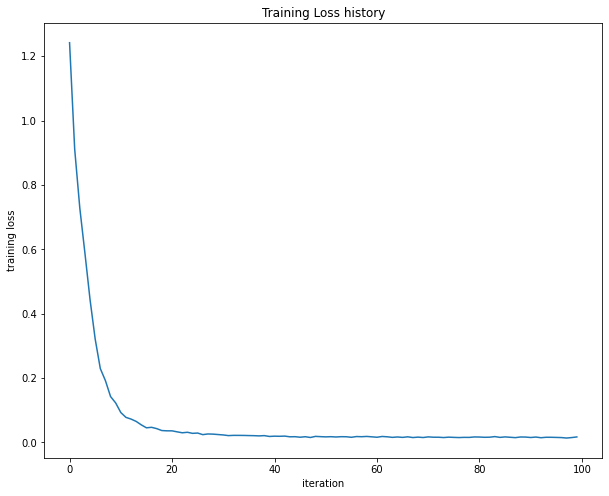

In [7]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# 加载数据

现在你已经实现了一个两层的神经网络，通过了梯度检查,并且在玩具数据有效工作，现在可以加载我们喜欢的CIFAR-10数据了(我不喜欢（╯‵□′）╯︵┴─┴ )，这样就可以训练真实数据集上的分类器。

In [8]:
from daseCV.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'daseCV/datasets/cifar-10-batches-py'
    
    # 清除变量,防止多次加载数据(这可能会导致内存问题)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# 训练网络

我们使用SGD训练网络。此外，在训练过程中,我们采用指数学习率衰减计划,把学习率乘以衰减率来降低学习率。

In [9]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)


iteration 0 / 1000: loss 2.302762
iteration 100 / 1000: loss 2.302358
iteration 200 / 1000: loss 2.297405
iteration 300 / 1000: loss 2.258897
iteration 400 / 1000: loss 2.202976
iteration 500 / 1000: loss 2.116818
iteration 600 / 1000: loss 2.049801
iteration 700 / 1000: loss 1.985725
iteration 800 / 1000: loss 2.003727
iteration 900 / 1000: loss 1.948067
Validation accuracy:  0.287


# Debug 训练过程

使用默认参数，验证集的验证精度应该在0.29左右。太差了

解决这个问题的一种策略是在训练过程中绘制损失函数, 以及训练集和验证集的准确度。

另一种策略是把网络的第一层权重可视化。在大多数以视觉数据为训练对象的神经网络中，第一层的权值在可视化时通常会显示有趣的结构。

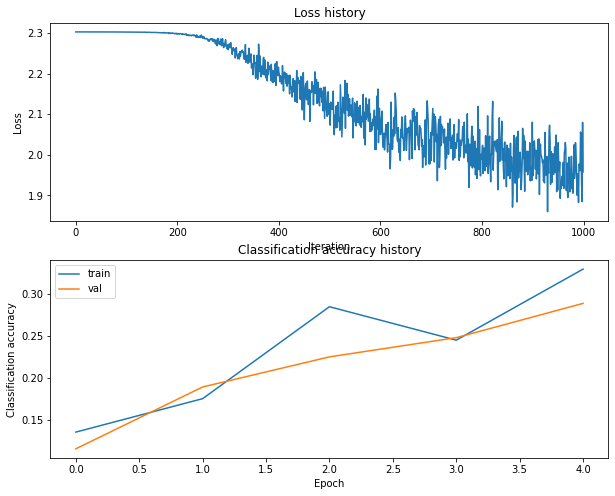

In [10]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend()
plt.show()

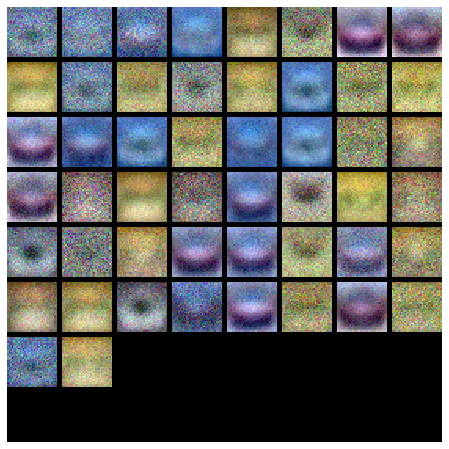

In [11]:
from daseCV.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()

show_net_weights(net)

# 调整超参数

**What's wrong?**. 查看上面的可视化，我们可以看到损失或多或少是线性下降的，这似乎表明学习率可能太小了。此外，训练的准确度和验证的准确度之间没有差距，这说明我们使用的模型容量较小，我们应该增加模型的大小。另一方面，对于一个非常大的模型，我们期望看到更多的过拟合，这表现为训练和验证准确度之间有非常大的差距。

**Tuning**. 调整超参数并了解它们如何影响最终的性能是使用神经网络的一个重要部分，因此我们希望你进行大量实践。下面，你应该试验各种超参数的不同值，包括隐层大小、学习率、训练周期数和正则化强度。你也可以考虑调整学习速率衰减，但是这个实验中默认值应该能够获得良好的性能。

**Approximate results**. 你应该在验证集上获得超过48%的分类准确率。我们最好的模型在验证集上获得超过52%的准确率。

**Experiment**: 在这个练习中，你的任务是使用一个全连接的神经网络，在CIFAR-10上获得尽可能好的结果(52%可以作为参考)。您可以自由地实现自己的技术(例如，使用PCA来降低维度，或添加dropout，或添加特征，等等)。

**在下面说明你的超参数搜索过程**

$\color{blue}{你的回答: }$  给定了几个超参数的取值，然后分别运行得到结果最好的

In [12]:
best_net = None # store the best model into this 

#################################################################################
# TODO：使用验证集调整超参数。 将您的最佳模型存储在best_net中。
# 使用上面用过的可视化手段可能能够帮助你调试网络。
# 可视化结果与上面比较差的网络有明显的差别。
# 手工调整超参数可能很有趣，但是你会发现编写代码自动扫描超参数的可能组合会很有用。     
#################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

best_acc = 0

input_size = 32 * 32 * 3
num_classes = 10

# Train the network
for bs in [200, 400]:
    for lr in [1e-3, 1e-4, 1e-5]:
        for hidden_size in [50, 100, 200]:
            net = TwoLayerNet(input_size, hidden_size, num_classes)
            stats = net.train(X_train, y_train, X_val, y_val,
                        num_iters=2000, batch_size=bs,
                        learning_rate=lr, learning_rate_decay=0.9,
                        reg=0.5, verbose=True)

            # Predict on the validation set
            val_acc = (net.predict(X_val) == y_val).mean()
            print ('batch_size = %d, lr = %f, hidden size = %f, Valid_accuracy: %f' %(bs, lr, hidden_size,val_acc))
            if val_acc > best_acc:
                best_acc = val_acc
                best_net = net

# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


iteration 0 / 2000: loss 2.302970
iteration 100 / 2000: loss 1.967770
iteration 200 / 2000: loss 1.761300
iteration 300 / 2000: loss 1.838307
iteration 400 / 2000: loss 1.682846
iteration 500 / 2000: loss 1.725149
iteration 600 / 2000: loss 1.609002
iteration 700 / 2000: loss 1.605850
iteration 800 / 2000: loss 1.533885
iteration 900 / 2000: loss 1.614207
iteration 1000 / 2000: loss 1.480595
iteration 1100 / 2000: loss 1.454163
iteration 1200 / 2000: loss 1.513307
iteration 1300 / 2000: loss 1.533797
iteration 1400 / 2000: loss 1.496025
iteration 1500 / 2000: loss 1.415547
iteration 1600 / 2000: loss 1.460225
iteration 1700 / 2000: loss 1.535198
iteration 1800 / 2000: loss 1.389774
iteration 1900 / 2000: loss 1.563373
batch_size = 200, lr = 0.001000, hidden size = 50.000000, Valid_accuracy: 0.493000
iteration 0 / 2000: loss 2.303356
iteration 100 / 2000: loss 1.903005
iteration 200 / 2000: loss 1.778160
iteration 300 / 2000: loss 1.651317
iteration 400 / 2000: loss 1.610417
iteration 5

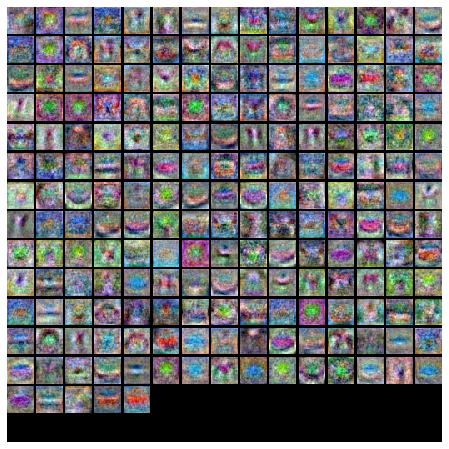

In [13]:
# visualize the weights of the best network
show_net_weights(best_net)

# 在测试集上面测试

当你完成实验时，你可以在测试集上评估你最终的模型；你应该得到48%以上的准确度。

In [14]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

Test accuracy:  0.514


**问题 2**


现在您已经完成训练了一个神经网络分类器，您可能会发现您的测试精度远远低于训练精度。我们可以用什么方法来缩小这种差距?选出下列正确的选项

1. 在更大的数据集上训练
2. 增加更多的隐藏单元
3. 增加正则化强度
4. 其他

$\color{blue}{\textit Your Answer:}$  1、3

$\color{blue}{\textit Your Explanation:}$

测试精度远远低于训练精度的一个原因是模型过拟合，在1,3下可以减少过拟合发生的可能性


---
# 重要

这里是作业的结尾处，请执行以下步骤:

防止作业被吞

1. 点击`File -> Save`或者用`control+s`组合键，确保你最新的的notebook的作业已经保存到谷歌云。
2. 执行以下代码确保 `.py` 文件保存回你的谷歌云。

In [15]:
# import os

# FOLDER_TO_SAVE = os.path.join('drive/My Drive/', FOLDERNAME)
# FILES_TO_SAVE = ['daseCV/classifiers/neural_net.py']

# for files in FILES_TO_SAVE:
#   with open(os.path.join(FOLDER_TO_SAVE, '/'.join(files.split('/')[1:])), 'w') as f:
#     f.write(''.join(open(files).readlines()))